# YOLOv3 커스텀 데이터 학습

copy from https://articlearn.id/article/e5571bb0-how-to-train-yolov3-on-google-colab-to-de/

# 학습 준비



## 데이터 준비

구글 드라이브 tmp/custom_object_detection 폴더에 laptops_labeled.zip 데이터 파일을 준비한다.

<br>
laptops_labeled.zip 파일 내용

```
1.jpg
1.txt
2.jpg
2.txt
...
```

<br>
레이블 데이터 내용

1.txt
```
0 0.498403 0.541966 0.559105 0.585132
```
한줄만 있다. 

첫번째 0은 클래스 인덱스, 

0.498403, 0.541966은 박스의 중심

0.559105, 0.585132는 박스의 폭과 높이





## 탐지할 대상 이름 설정

In [21]:
CUSTOM_OBJECT_NAMES = ['laptop', 'keyboard']

## 0. 임포트

In [2]:
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab import drive

## 1. 구글 드라이브 마운트, mydrive로 링크

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ln -s /content/gdrive/MyDrive/ /mydrive

## 2. Darknet 다운받아서 컴파일

In [5]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15308, done.
remote: Total 15308 (delta 0), reused 0 (delta 0), pack-reused 15308
Receiving objects: 100% (15308/15308), 13.69 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (10404/10404), done.


OpenCV, GPU, CuDNN 사용 관련 설정하고 컴파일

In [8]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

## 3. 학습관련 설정 파일 수정

원 설정파일 yolov3.cfg를 yolv3_custom.cfg로 복사하고

복사한 설정파일을 수정

In [9]:
# %cd darknet

# Make a copy & rename it to yolov3_custom.cfg
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

In [10]:
# Change classes value to your number of objects
classes = len(CUSTOM_OBJECT_NAMES)
filters = (classes + 5) * 3
max_batches = classes * 2000

if max_batches < 6000:
  max_batches = 6000

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg

## 4. 데이터 가져오기
- darknet/data/obj에 latops_labeled.zip 압축 풀기
- classes.names와 training.data 파일 생성
- training.txt 파일 생성


In [11]:
!ls -al /mydrive/cau_temp/laptops_labeled.zip

-rw------- 1 root root 709303 Aug 27 05:29 /mydrive/cau_temp/laptops_labeled.zip


In [12]:
!rm -rf data/obj
!mkdir data/obj
!unzip /mydrive/cau_temp/laptops_labeled.zip -d data/obj

Archive:  /mydrive/cau_temp/laptops_labeled.zip
   creating: data/obj/laptops_labeled/
  inflating: data/obj/__MACOSX/._laptops_labeled  
  inflating: data/obj/laptops_labeled/.DS_Store  
  inflating: data/obj/__MACOSX/laptops_labeled/._.DS_Store  
  inflating: data/obj/laptops_labeled/12.txt  
  inflating: data/obj/__MACOSX/laptops_labeled/._12.txt  
  inflating: data/obj/laptops_labeled/8.jpg  
  inflating: data/obj/__MACOSX/laptops_labeled/._8.jpg  
  inflating: data/obj/laptops_labeled/10.txt  
  inflating: data/obj/__MACOSX/laptops_labeled/._10.txt  
  inflating: data/obj/laptops_labeled/11.txt  
  inflating: data/obj/__MACOSX/laptops_labeled/._11.txt  
  inflating: data/obj/laptops_labeled/9.jpg  
  inflating: data/obj/__MACOSX/laptops_labeled/._9.jpg  
  inflating: data/obj/laptops_labeled/12.jpg  
  inflating: data/obj/__MACOSX/laptops_labeled/._12.jpg  
  inflating: data/obj/laptops_labeled/11.jpg  
  inflating: data/obj/__MACOSX/laptops_labeled/._11.jpg  
  inflating: data/ob

학습에 직접 사용할 data/obj.names, data/obj.data, data/train.txt 파일을 생성한다.

<br>

data/obj.names
```
laptop
keyboard
```

<br>

data/obj.data
```
classes = 1
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/tmp/custom_object_detection
```

<br>

data/train.txt
```
data/obj/9.jpg
data/obj/12.jpg
data/obj/5.jpg
data/obj/3.jpg
data/obj/1.jpg
...
```



In [44]:
# Add your object names to this list
custom_objects = CUSTOM_OBJECT_NAMES

objects = "\n".join(custom_objects)

!echo -e '$objects' > data/obj.names
!echo -e 'classes = $classes\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/cau_temp' > data/obj.data

In [48]:
!cat data/obj.names

laptop
keyboard


In [49]:
!cat data/obj.data

classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/cau_temp


In [52]:
!ls -al data
!ls -al data/obj
!ls -al data/obj/laptops
!ls -al data/obj/laptops_labeled

total 16
drwxr-xr-x 4 root root 4096 Aug 27 05:48 .
drwxr-xr-x 4 root root 4096 Aug 27 06:04 ..
drwxr-xr-x 2 root root 4096 Aug 27 05:28 laptops_labeled
drwxr-xr-x 3 root root 4096 Aug 27 05:48 __MACOSX


In [54]:
# ls -al data/obj/laptops_labeled 밑에 jpg 파일들이 있으면
images_list = glob.glob("data/obj/laptops_labeled/*[jpg|png|jpeg]")

# ls -al data/obj 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['data/obj/laptops_labeled/7.jpg', 'data/obj/laptops_labeled/6.jpg', 'data/obj/laptops_labeled/2.jpg', 'data/obj/laptops_labeled/4.jpg', 'data/obj/laptops_labeled/8.jpg', 'data/obj/laptops_labeled/5.jpg', 'data/obj/laptops_labeled/3.jpg', 'data/obj/laptops_labeled/12.jpg', 'data/obj/laptops_labeled/9.jpg', 'data/obj/laptops_labeled/11.jpg', 'data/obj/laptops_labeled/10.jpg', 'data/obj/laptops_labeled/1.jpg']


In [55]:
!cat data/train.txt

data/obj/laptops_labeled/7.jpg
data/obj/laptops_labeled/6.jpg
data/obj/laptops_labeled/2.jpg
data/obj/laptops_labeled/4.jpg
data/obj/laptops_labeled/8.jpg
data/obj/laptops_labeled/5.jpg
data/obj/laptops_labeled/3.jpg
data/obj/laptops_labeled/12.jpg
data/obj/laptops_labeled/9.jpg
data/obj/laptops_labeled/11.jpg
data/obj/laptops_labeled/10.jpg
data/obj/laptops_labeled/1.jpg

## 5. 학습된 YOLOv3 모델 파일 다운로드

In [56]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-08-27 06:27:25--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  50.6MB/s    in 3.2s    

2021-08-27 06:27:29 (48.6 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## 6. 학습 실행

학습된 모델은  /mydrive/tmp/custom_object_detection/yolov3_custom_last.weights 로 저장된다.

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 1.673154, iou_loss = 0.000000, total_loss = 1.673154 
 total_bbox = 27253, rewritten_bbox = 0.480681 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.433820), count: 8, class_loss = 4.653390, iou_loss = 3.209743, total_loss = 7.863133 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.516606), count: 2, class_loss = 2.754764, iou_loss = 0.557940, total_loss = 3.312704 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 1.679684, iou_loss = 0.000000, total_loss = 1.679684 
 total_bbox = 27263, rewritten_bbox = 0.484173 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.523680), count: 8, class_loss = 4.737838, iou_loss = 3.211566, total_loss = 7.949404 
v3 (mse loss, Normaliz

## 7. 탐지 실행

In [57]:
!./darknet detect cfg/yolov3_custom.cfg /mydrive/tmp/custom_object_detection/yolov3_custom_last.weights data/obj/1.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

In [ ]:
# !./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/tmp/custom_object_detection/yolov3_custom_last.weights -thresh 0.25

^C


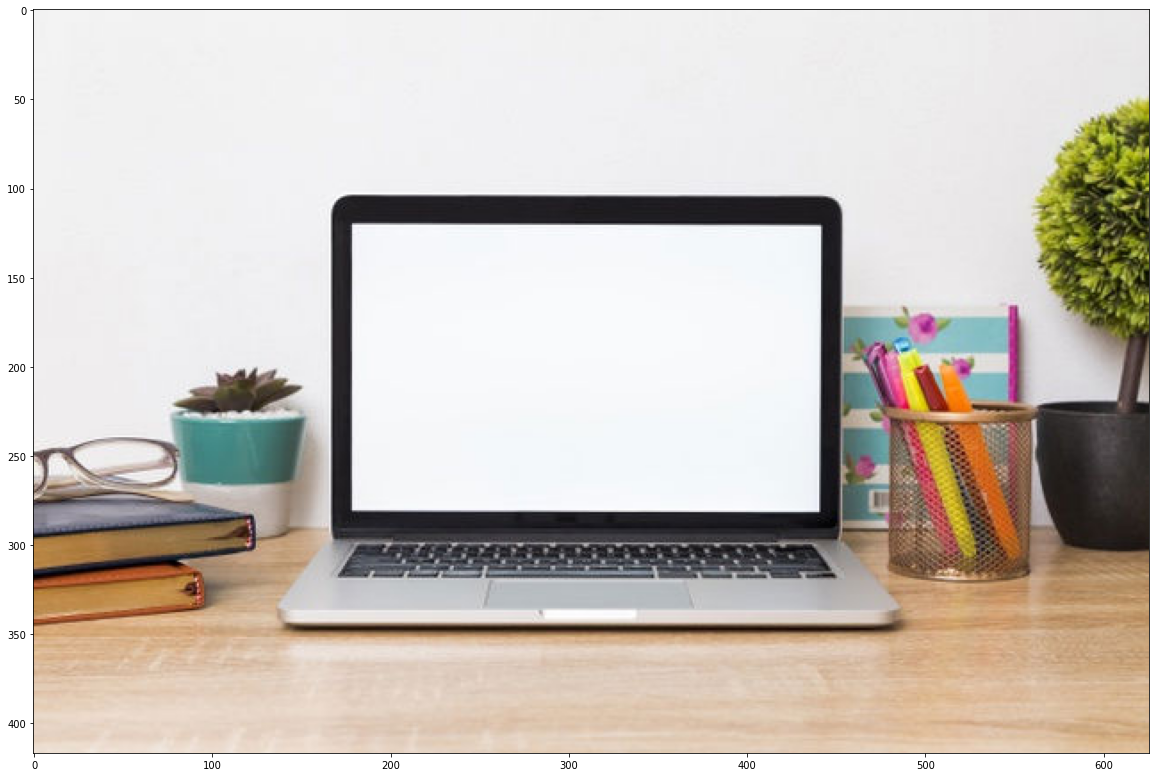

In [ ]:
pred = cv2.imread('predictions.jpg')
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(pred)